# Data Wrangling: Acquisition & Preparation

In this lesson, we'll be acquiring and preparing some data from our SQL database.

## Learning Goals:

    
- Acquire a sample of data from SQL.
- Identify null values, which nulls are 'deal-breakers', i.e. rows removed, which nulls should be represented by 0, and which should be replaced by a value from other methods, such as mean.		
- Identify outliers and decide what to do with them, if anything (remove, keep as-is, replace).
- Data Structure: Aggregate as needed so that every row is an observation and each column is a variable (1 variable and not a measure). 

In [34]:
# regular imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import env
# from acquire import get_mallcustomer_data()

In [35]:
# from our acquire.py:
def get_connection(db, user=env.username, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    
def get_mallcustomer_data():
    df = pd.read_sql('SELECT * FROM customers;', get_connection('mall_customers'))
    return df.set_index('customer_id')

In [36]:
# acquire our dataframe

In [37]:
df = get_mallcustomer_data()

In [38]:
type(df)

pandas.core.frame.DataFrame

### Acquire & Summarize

In [39]:
# How do we get a summarization of our data?

In [42]:
df.describe()

,age,annual_income,spending_score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [ ]:
# summary of data:
# .head()
# .info()
# .describe()
# value_counts() *spread of data
# observe nulls in the dataframe
#      deal with nulls accordingly:
#      -fillna(0)
#      -fillna(value/mean/mode)//sklearn.imputer(only after split)
#      -drop

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [43]:
df.shape[0]

200

In [44]:
# pandas axes:
# rows: r0ws
# cols: co1s

In [45]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    prcnt_miss = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing

def nulls_by_row(df):
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(index=str, columns={'customer_id': 'num_rows'}).reset_index()
    return rows_missing

In [46]:
print(nulls_by_row(df).to_markdown())

|    |   num_cols_missing |   percent_cols_missing |   num_rows |
|---:|-------------------:|-----------------------:|-----------:|
|  0 |                  0 |                      0 |        200 |


In [47]:
def summarize(df):
    '''
    summarize will take in a single argument (a pandas dataframe) 
    and output to console various statistics on said dataframe, including:
    # .head()
    # .info()
    # .describe()
    # value_counts()
    # observation of nulls in the dataframe
    '''
    print('=====================================================\n\n')
    print('Dataframe head: ')
    print(df.head(3).to_markdown())
    print('=====================================================\n\n')
    print('Dataframe info: ')
    print(df.info())
    print('=====================================================\n\n')
    print('Dataframe Description: ')
    print(df.describe().to_markdown())
    num_cols = [col for col in df.columns if df[col].dtype != 'O']
    cat_cols = [col for col in df.columns if col not in num_cols]
    print('=====================================================')
    print('DataFrame value counts: ')
    for col in df.columns:
        if col in cat_cols:
            print(df[col].value_counts())
        else:
            print(df[col].value_counts(bins=10, sort=False))
    print('=====================================================')
    print('nulls in dataframe by column: ')
    print(nulls_by_col(df))
    print('=====================================================')
    print('nulls in dataframe by row: ')
    print(nulls_by_row(df))
    print('=====================================================')

In [48]:
summarize(df)



Dataframe head: 
|   customer_id | gender   |   age |   annual_income |   spending_score |
|--------------:|:---------|------:|----------------:|-----------------:|
|             1 | Male     |    19 |              15 |               39 |
|             2 | Male     |    21 |              15 |               81 |
|             3 | Female   |    20 |              16 |                6 |


Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB
None


Dataframe Description: 
|       |     age |   annual_income |   spending_score |
|:------|--------:|----------------:|-----------------:|
| count | 200     |        20

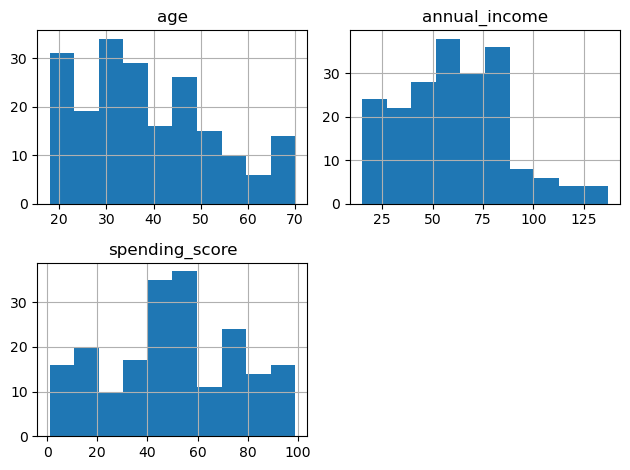

In [49]:
df.hist()
plt.tight_layout()
plt.show()

In [21]:
# hypothetical // practical removal of nulls:

In [50]:
def remove_columns(df, cols_to_remove):
    df = df.drop(columns=cols_to_remove)
    return df

In [51]:
def handle_missing_values(df, prop_required_columns=0.5, prop_required_row=0.75):
    threshold = int(round(prop_required_columns * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold)
    return df

In [52]:
# combining everything in a cleaning function:

def data_prep(df, cols_to_remove=[], prop_required_column=0.5, prop_required_row=0.75):
    df = remove_columns(df, cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [53]:
df = data_prep(df)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [27]:
# Handling Outliers:
# note your use-case! (handle outliers approrpriately. 
# ( Do we want to drop them? )
# z-score: appropriate for normal data, based on normal distribution
# Tukey: utilizing fences with inner quartile range, not contingent on normality

In [28]:
# to utilize tukeys method:
# calculate iqr:
# get Q3 and Q1, get difference (q3 - q1)
# establish fences: 
## standard inner fence: 1.5
## standard outer fence: 3
# upper bound: q3 + k * iqr
# lower bound: q1 - k * iqr

In [55]:
def get_upper_outliers(s, k=1.5):
    q1, q3 = s.quantile([.25, 0.75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

In [56]:
def add_upper_outlier_columns(df, k=1.5):
    for col in df.select_dtypes('number'):
        df[col + '_outliers_upper'] = get_upper_outliers(df[col], k)
    return df

In [57]:
df = add_upper_outlier_columns(df)

In [58]:
df.head()

,gender,age,annual_income,spending_score,age_outliers_upper,annual_income_outliers_upper,spending_score_outliers_upper
customer_id,,,,,,,
1,Male,19,15,39,0,0.0,0
2,Male,21,15,81,0,0.0,0
3,Female,20,16,6,0,0.0,0
4,Female,23,16,77,0,0.0,0
5,Female,31,17,40,0,0.0,0


In [59]:
outlier_cols = [col for col in df.columns if col.endswith('_outliers_upper')]
for col in outlier_cols:
    print(col, ': ')
    subset = df[col][df[col] > 0]
    print(subset.describe())

age_outliers_upper : 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: age_outliers_upper, dtype: float64
annual_income_outliers_upper : 
count    2.00
mean     4.25
std      0.00
min      4.25
25%      4.25
50%      4.25
75%      4.25
max      4.25
Name: annual_income_outliers_upper, dtype: float64
spending_score_outliers_upper : 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: spending_score_outliers_upper, dtype: float64


In [ ]:
# we have:
# in an organized fashion:
# acquired our data
# examined the structure and integrity of the data
# we hav observed descriptive statistics (univariate)
# we have examined null values in a nuanced fashion
# we have examined where our outliers live and assessed how we want to approach them
 # (Takeaway: our outliers exist in income, they appear to be valid and I will not 
    # drop them at this time)

---
> Exercise Function Calls:
---

# Exercises

Within your `codeup-data-science` directory, create a new directory named `clustering-exercises`. This will be where you do your work for this module. Create a repository on GitHub with the same name, and link your local repository to GitHub.

Save your clustering work in your `clustering-exercises` repo. Then add, commit, and push your changes.

For example, if the
exercise directs you to create a file named `myfile.py`, you should have
`clustering/myfile.py` in your repository.

If a file extension is specified, you should create that specific file. If there
is not file extension specified, you may either create a python script or a
jupyter notebook for the exercise.

!!!tip "Workflow"
    Throughout the exercises, you may wish to do your work in a notebook, then
    transfer any functions you've created to an external python script.

    Keep in mind this is not always a linear process! You will probably be
    cycling between a notebook and an external python script frequently.

    Remember to run your code often to check for correct output and/or errors.

## Acquire (acquire.py)

### Zillow

For the following, iterate through the steps you would take to create functions:
Write the code to do the following in a jupyter notebook, test it, convert to functions, then create the file to house those functions. 

You will have a zillow.ipynb file and a helper file for each section in the pipeline. 


#### acquire & summarize

1. Acquire data from mySQL using the python module to connect and query. You will want to end with a single dataframe. Make sure to include: the logerror, all fields related to the properties that are available. You will end up using all the tables in the database. 
    - **_Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for `airconditioningtypeid`._**  
    - Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction.  
    - Only include properties that include a latitude and longitude value.  

2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)
3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values. 

|                          | num_rows_missing | pct_rows_missing  |
| ------------------------ |-----------------:| -----------------:|
| parcelid                 | 0                | 0.000000          |
| airconditioningtypeid    | 29041            | 0.535486          |
| architecturalstyletypeid | 54232            | 0.999982          |


4. Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values. 


| num_cols_missing  | pct_cols_missing | num_rows  |
| ----------------- |-----------------:| ---------:|
| 23                | 38.333           | 108       |
| 24                | 40.000           | 123       |
| 25                | 41.667           | 5280      |

#### Prepare 

1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.  

1. Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).  
    - The input:
        - A dataframe
        - A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column.  i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing).
        - A number between 0 and 1 that represents the proportion, for each row, of columns/variables with non-missing values required to keep the row. For example, if prop_required_row = .75, then you are requiring a row to have at least 75% of variables with a non-missing value (no more that 25% missing). 
    - The output:
        - The dataframe with the columns and rows dropped as indicated. *Be sure to drop the columns prior to the rows in your function.*
    - hint:
        - Look up the dropna documentation. 
        - You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
        - Make use of inplace, i.e. inplace=True/False.

1. Decide how to handle the remaining missing values: 
    - Fill with constant value.
    - Impute with mean, median, mode.
    - Drop row/column
    

#### wrangle_zillow.py

Functions of the work above needed to acquire and prepare a new sample of data. 


### Mall Customers

#### notebook

1. Acquire data from mall_customers.customers in mysql database. 
2. Summarize data (include distributions and descriptive statistics).
2. Detect outliers using IQR.
3. Split data (train, validate, and test split).
3. Encode categorical columns using a one hot encoder (pd.get_dummies).
4. Handles missing values.
5. Scaling

#### wrangle_mall.py 

1. Acquire data from mall_customers.customers in mysql database. 
2. Split the data into train, validate, and split
3. One-hot-encoding (pd.get_dummies)
3. Missing values
4. Scaling

In [4]:
import wrangle_excs

In [5]:
df = wrangle_excs.wrangle_zillow()

In [8]:
acq = pd.read_csv('zillow_cached.csv')

/opt/homebrew/anaconda3/envs/homebase/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (62) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
acq.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [11]:
acq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77575 entries, 0 to 77574
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77575 non-null  int64  
 1   airconditioningtypeid         25006 non-null  float64
 2   architecturalstyletypeid      206 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77575 non-null  float64
 5   bedroomcnt                    77575 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76960 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6035 non-null   float64
 11  calculatedfinishedsquarefeet  77375 non-null  float64
 12  finishedsquarefeet12          73920 non-null  float64
 13  f

In [13]:
wrangle_excs.summarize(acq)



Dataframe head: 
|    |   parcelid |   airconditioningtypeid |   architecturalstyletypeid |   basementsqft |   bathroomcnt |   bedroomcnt |   buildingclasstypeid |   buildingqualitytypeid |   calculatedbathnbr |   decktypeid |   finishedfloor1squarefeet |   calculatedfinishedsquarefeet |   finishedsquarefeet12 |   finishedsquarefeet13 |   finishedsquarefeet15 |   finishedsquarefeet50 |   finishedsquarefeet6 |   fips |   fireplacecnt |   fullbathcnt |   garagecarcnt |   garagetotalsqft |   hashottuborspa |   heatingorsystemtypeid |    latitude |    longitude |   lotsizesquarefeet |   poolcnt |   poolsizesum |   pooltypeid10 |   pooltypeid2 |   pooltypeid7 |   propertycountylandusecode |   propertylandusetypeid |   propertyzoningdesc |   rawcensustractandblock |   regionidcity |   regionidcounty |   regionidneighborhood |   regionidzip |   roomcnt |   storytypeid |   threequarterbathnbr |   typeconstructiontypeid |   unitcnt |   yardbuildingsqft17 |   yardbuildingsqft26 |   yearbuilt |

In [1]:
import wrangle_excs

In [2]:
df = wrangle_excs.wrangle_zillow()

/opt/homebrew/anaconda3/envs/homebase/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (62) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/madeleinecapper/Documents/exercise_selfwork/germain/clustering/wrangle_excs.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=0, thresh=threshold, inplace=True)


In [3]:
wrangle_excs.summarize(df)



Dataframe head: 
|    |   bathroomcnt |   bedroomcnt |   buildingqualitytypeid |   calculatedfinishedsquarefeet |   fips |    latitude |    longitude |   lotsizesquarefeet |   rawcensustractandblock |   regionidcity |   regionidcounty |   regionidzip |   roomcnt |   unitcnt |   yearbuilt |   structuretaxvaluedollarcnt |   taxvaluedollarcnt |   assessmentyear |   landtaxvaluedollarcnt |   taxamount |   logerror | transactiondate   | heatingorsystemdesc   | county   |
|---:|--------------:|-------------:|------------------------:|-------------------------------:|-------:|------------:|-------------:|--------------------:|-------------------------:|---------------:|-----------------:|--------------:|----------:|----------:|------------:|-----------------------------:|--------------------:|-----------------:|------------------------:|------------:|-----------:|:------------------|:----------------------|:---------|
|  0 |           3.5 |            4 |                       6 |          

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69681 entries, 0 to 77574
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   69681 non-null  float64
 1   bedroomcnt                    69681 non-null  float64
 2   buildingqualitytypeid         69681 non-null  float64
 3   calculatedfinishedsquarefeet  69681 non-null  float64
 4   fips                          69681 non-null  float64
 5   latitude                      69681 non-null  float64
 6   longitude                     69681 non-null  float64
 7   lotsizesquarefeet             69681 non-null  float64
 8   rawcensustractandblock        69681 non-null  float64
 9   regionidcity                  69681 non-null  float64
 10  regionidcounty                69681 non-null  float64
 11  regionidzip                   69681 non-null  float64
 12  roomcnt                       69681 non-null  float64
 13  u

In [10]:
scaler, train, val, test = wrangle_excs.wrangle_mall_df()

/Users/madeleinecapper/Documents/exercise_selfwork/germain/clustering/wrangle_excs.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[num_vars] = scaler.transform(test[num_vars])
/opt/homebrew/anaconda3/envs/homebase/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 182 to 59
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             118 non-null    float64
 1   annual_income   118 non-null    float64
 2   spending_score  118 non-null    float64
 3   Male            118 non-null    float64
dtypes: float64(4)
memory usage: 4.6 KB


In [14]:
test.head()

,age,annual_income,spending_score,Male
customer_id,,,,
157,0.365385,0.567568,0.000000,1.0
27,0.519231,0.117117,0.316327,0.0
63,0.942308,0.288288,0.520408,0.0
32,0.057692,0.135135,0.734694,0.0
21,0.326923,0.081081,0.346939,1.0
